In [2]:
# 导入包
import matplotlib.pyplot as plt
import numpy as np
import scipy

In [3]:
# 全局基本常数
import astropy.constants as const
import astropy.units as u

const_c =  const.c.value

distance_gpc = 1 * u.Mpc
distance_km = distance_gpc.to(u.km)
time_gyr = 1 * u.Gyr
time_s = time_gyr.to(u.s)
# 单位转换(1/H0 to Gyr)
transfer = distance_km / time_s

### 方程求解

$z''(t)=\frac{H_0^4\kappa C_1\Omega_{1,0}^2(z(t)^4+1)+3H_0^4\Omega_{1,0}^2z(t)^2(2\kappa C_1-3z'(t))+H_0^4\Omega_{1,0}^2z(t)^3(4\kappa C_1-3z'(t))-3H_0^4\Omega_{1,0}^2z'(t)+5H_0^2\Omega_{1,0}z'(t)^3-\kappa C_1z'(t)^4+H_0^2\Omega_{1,0}z(t)(4H_0^2\kappa C_1\Omega_{1,0}-9H_0^2\Omega_{1,0}z'(t)+5z'(t)^3)}{2H_0^2\Omega_{1,0}(1+z(t))^2z'(t)}$

>$\Omega_{1,0}=1-\Omega_{2,0}\to \text{O10},\Omega_{2,0}\to \text{O20},\kappa C_1\to \text{kC1}$

In [14]:
# 把z重构为向量函数 z = [dz0,dz1,dz2]
def function(t, z, kC1, O10, H0):
    # z[0] = z(t), z[1] = z'(t), z[2] = z''(t)
    dz1 = z[1]
    # 减少括号的使用,分为分子与分母
    up = H0**4 * kC1 * O10**2 * (z[0]**4+1) + 3 * H0**4 * O10**2 * z[0]**2 * (2 * kC1-3 * z[1]) \
        + H0**4 * O10**2 * z[0]**3 * (4 * kC1 - 3 * z[1]) - 3 * H0**4 * O10**2 * z[1] + 5 * H0**2 * O10 * z[1]**3\
            - kC1 * z[1]**4 + H0**2 * O10 * z[0] * (4 * H0**2 * kC1 * O10 - 9 * H0**2 * O10 * z[1] + 5 * z[1]**3)
    down = 2 * H0**2 * O10 * (1 + z[0])**2 * z[1]
    dz2 = up / down
    return [dz1, dz2]

In [15]:
# 求解原方程对应的z(t)与z'(t)
def solution(log_kC1, O20, H0):
    # 转换单位
    kC1 = 10**log_kC1*transfer
    O10 = 1 - O20
    t0 = 1 / H0
    # 求解区间
    tspan = (t0, 0)
    tn = np.linspace(t0, 0, 100000)
    # 从t0开始
    zt0 = [0, -H0]

    # t0给定初值
    z = scipy.integrate.solve_ivp(function, t_span=tspan, y0=zt0, t_eval=tn, method='RK45', args=(kC1, O10, H0))
    # z.y[0,:] = z(t), z.y[1,:] = z'(t)
    return z

### OHD(only CC)

In [ ]:
# 计算Hz的理论值
def Hz(z_list, log_kC1, O20, H0):
    z = solution(log_kC1, O20, H0)
    # 获取对应的解
    z_values = np.array(z.y[0, :])
    z1_values = np.array(z.y[1, :])
    z_list = np.array(z_list)
    # 查找对应的z值
    idx = np.searchsorted(z_values, z_list)
    z1 = z1_values[idx]
    H_th = (-1 / (1 + z_list) * z1)
    return H_th

$H(z)=-\dfrac{1}{1+z}\dfrac{\text{d}z}{\text{d}t}$

In [19]:
def OHD(log_kC1, O20, H0):
    # 从csv文件中读取数据
    file_path = "./OHD/OHD.csv"
    pandata = np.loadtxt(file_path, delimiter=',', skiprows=1)
    z_hz = pandata[:, 0]
    H_z = pandata[:, 1]
    err_H = pandata[:, 2]

    # 画图比较
    plt.figure()
    plt.plot(z_hz, Hz(z_hz, log_kC1, O20, H0), label='Theory', zorder=2)
    plt.errorbar(z_hz, H_z, yerr=err_H, fmt='.',color='black', elinewidth=1, capsize=2, label='Observation', zorder=1)
    plt.xlabel('$z$')
    plt.ylabel('$H(z)$')
    plt.legend()
    plt.show()

### SNe Ia

$\displaystyle d_L=c(1+z)\int_0^z\frac{dz'}{H(z')}=c(1+z)\left[t_0-t+\int_t^{t_0}z(t')dt'\right]$

In [ ]:
# 计算光度距离
def D_L(z_list, log_kC1, O20, H0):
    z = solution(log_kC1, O20, H0)
    t0 = 1 / H0
    # 获取对应的解
    t_values = np.array(z.t)
    z_values = np.array(z.y[0, :])
    z_list = np.array(z_list)

    dl_values = []

    for z_hz_value in z_list:
        # 找到 z_hz_value 在 z_values 中的位置
        idx = np.searchsorted(z_values, z_hz_value)
        # 如果 z_hz_value 超出了 z_values 的范围，使用最后一个值
        if idx >= len(z_values):  
            idx = len(z_values) - 1
        # 使用梯形规则计算 z0 和 z1 之间的面积
        int_value = -np.trapz(z_values[:idx], t_values[:idx])
        dl_value = const_c * (1 + z_hz_value) * (t0 - t_values[idx] + int_value)
        dl_values.append(dl_value)

    return dl_values

$m=M+5\log(d_L)+25$

In [ ]:
# 计算视星等
def m_b(z_list, log_kC1, O20, H0, Mb):
    dl = np.array(D_L(z_list, log_kC1, O20, H0))
    m_b = 5 * np.log10(dl) + 25 + Mb
    return m_b

In [20]:
def SNe_Ia(log_kC1, O20, H0, Mb):
    # 从txt文件中读取数据
    file_path = "./SNe Ia/Pantheon.txt"
    pandata = np.loadtxt(file_path, skiprows=3, usecols=(1, 4, 5))
    z_hz = pandata[:, 0]
    m = pandata[:, 1]
    err_m = pandata[:, 2]

    # 按照z_hz的大小排序
    idx = np.argsort(z_hz)
    z_hz = z_hz[idx]
    m = m[idx]
    err_m = err_m[idx]

    # 画图比较
    plt.figure()
    plt.plot(z_hz, m_b(z_hz, log_kC1, O20, H0, Mb), label='Theory', zorder=2)
    plt.errorbar(z_hz, m, yerr=err_m, fmt='.',color='black', elinewidth=1, capsize=2, label='Observation', zorder=1)
    plt.xlabel('$z$')
    plt.ylabel('$m_b$')
    plt.legend()
    plt.show()

### BAO

### CMB

### 与原始数据对比

In [ ]:
def main():
    OHD(log_kC1=-3, O20=0.26, H0=70)
    SNe_Ia(log_kC1=-3, O20=0.28, H0=70, Mb=-19.3)


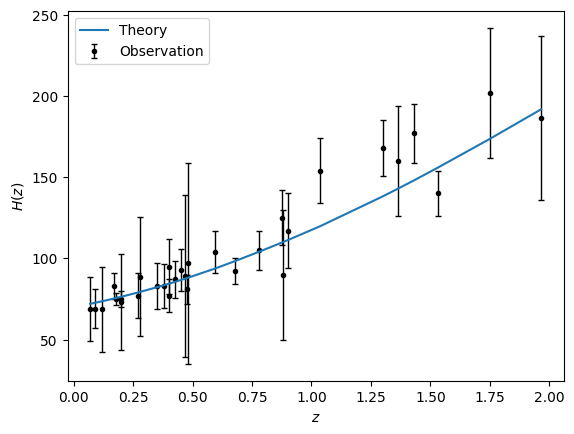

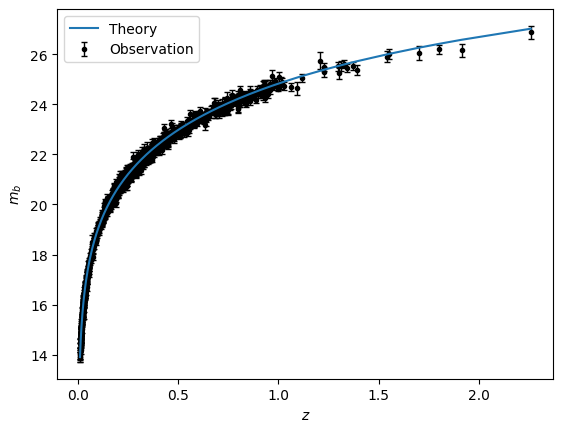

In [ ]:
if __name__ == '__main__':
    main()